This notebook is a code-along to Andrej's lesson: https://www.youtube.com/watch?v=TCH_1BHY58I.
It is based on this 2003 paper: https://jmlr.org/papers/volume3/bengio03a/bengio03a.pdf


He provides a dataset of names as an example, and we'll makemore names. The next cell explores the dataset.

In [1]:
# Create data sets
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

SEP_CHAR = '.'  # Separator character signifying end or start of a word
BLOCK_SIZE = 3  # Number of previous characters to use as input to predict the next character

def build_dataset(words):
    # Create a dataset as one-hot encoded vectors
    x, y = [], []
    for w in words:
        context = [0] * BLOCK_SIZE  # Start with a BLOCK_SIZE of SEP_CHAR's
        for ch in w + SEP_CHAR:
            ix = ctoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix] # Crop and append
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y

# Read in the names
words = open("names.txt").read().splitlines()

# Create mapping from characters to integers and vice versa
ctoi = {c:i + 1 for i,c in enumerate(sorted(list(set(''.join(words)))))}
ctoi[SEP_CHAR] = 0
itoc = {i:c for c,i in ctoi.items()}
NUM_CHARS = len(ctoi)

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print (f"Training, dev, test sets have {Xtr.shape[0]}, {Xdev.shape[0]}, {Xte.shape[0]} words")

Training, dev, test sets have 182625, 22655, 22866 words


In [2]:
# Create a model
class Model():
    """ Model for predicting the next character given a sequence of characters """
    def __init__(self, embedding_dims, layer_dims):
        self.C = torch.randn((NUM_CHARS, embedding_dims))  # A map of characters to their embeddings
        self.C.requires_grad = True
        self.layers = [torch.nn.Linear(nin, nout) for nin, nout in zip(layer_dims[:-1], layer_dims[1:])]
        self.parameters = [self.C] + [p for l in self.layers for p in l.parameters()]

    def __call__(self, x):
        emb = self.C[x]
        emb = emb.view (x.shape[0], -1)
        for l in self.layers:
            emb = l(emb)
            if l != self.layers[-1]:
                emb = torch.relu(emb)
        return emb

    def parameters(self):
        return self.parameters

    def zero_grad(self):
        for p in self.parameters:
            p.grad = None

    def step(self, lr):
        for p in self.parameters:
            p.data -= lr * p.grad

    def __repr__(self):
        repr = f"Model with {len(model.parameters)} parameters and {sum([p.numel() for p in model.parameters])} trainable elements\n"
        for layer_num, layer in enumerate(self.layers):
            repr += f"\tLayer {layer_num}: \tinput size={layer.in_features}, output size={layer.out_features}\n"
        return repr

DIMS = 10               # Embedding dimension
HIDDEN_UNITS = 200      # Number of hidden units
model = Model(DIMS, [DIMS * BLOCK_SIZE, HIDDEN_UNITS, HIDDEN_UNITS, NUM_CHARS])
loss_fn = F.cross_entropy

print (model)

Model with 7 parameters and 52097 trainable elements
	Layer 0: 	input size=30, output size=200
	Layer 1: 	input size=200, output size=200
	Layer 2: 	input size=200, output size=27



In [5]:
# Train the model
def train(x, y, steps, batch_size=None, lr=.001):
    print (f"Training the model with input shape {x.shape}, output shape {y.shape}, steps={steps}, batch_size={batch_size}, lr={lr}")
    losses = []
    if batch_size is None:
        batch_size = x.shape[0]
    for _ in range(steps):
        # sample a random subset of the training data
        ix_batch = torch.randint(0, x.shape[0], (batch_size,))
        x_batch = x[ix_batch]
        y_batch = y[ix_batch]

        # forward pass
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        losses.append(loss.log10().item())

        # backwards pass
        model.zero_grad()
        loss.backward()

        # update parameters
        model.step(lr)

    print (f"loss = {loss.item()}")
    plt.plot(list(range(len(losses))), losses)

Training the model with input shape torch.Size([182625, 3]), output shape torch.Size([182625]), steps=10000, batch_size=32, lr=0.1
loss = 1.7653453350067139
Training the model with input shape torch.Size([182625, 3]), output shape torch.Size([182625]), steps=40000, batch_size=32, lr=0.01
loss = 1.7195919752120972


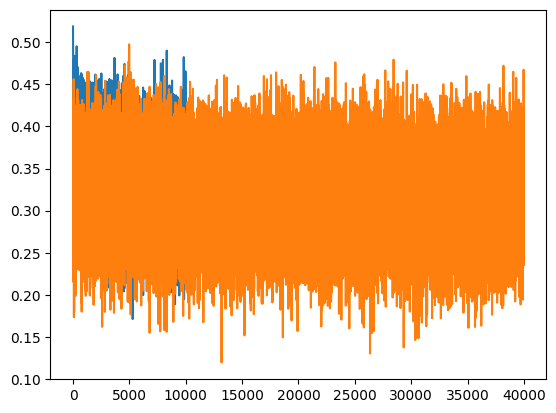

In [6]:
# Andrej gave a challenge to beat a loss of 2.17 on the dev set. This does it

train(Xtr, Ytr, steps=10000, lr=0.1, batch_size=32) # dev loss = 2.2 after this
train(Xtr, Ytr, steps=40000, lr=0.01, batch_size=32) # dev loss = 2.12 after this


Training loss = 2.0831193923950195
Dev loss = 2.1185572147369385
Test loss = 2.11214017868042
waycio
emmalynet
riyana
maedu
syodurminslelili
aniya
ela
zashleigh
martortlawbellon
rymar


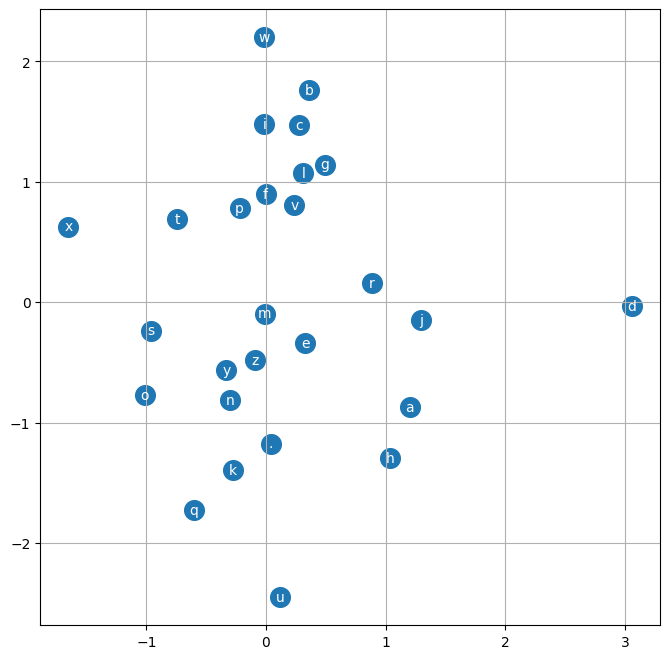

In [7]:
# Test the model and visualize the embeddings
def test(x, y):
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    print (f"loss = {loss.item()}")

# Visualize the embeddings
def visualize_embeddings():
    plt.figure(figsize=(8,8))
    C = model.C
    plt.scatter(C[:,0].data, C[:,1].data, s=200)
    for i in range(NUM_CHARS):
        plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="white")
    plt.grid("minor")
    plt.show()

def makemore(num):
    # Generate num new names
    for _ in range(num):
        context = [0] * BLOCK_SIZE
        name = ""
        while True:
            logits = model(torch.tensor(context).view(1, -1))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            if ix == 0:
                break
            name += itoc[ix]
            context = context[1:] + [ix]
        print (name)

print ("Training ", end="")
test(Xtr, Ytr)
print ("Dev ", end="")
test(Xdev, Ydev)
print ("Test ", end="")
test(Xte, Yte)

makemore(10)

visualize_embeddings()